# Quick Start (PyTorch)

Welcome to the quick start guide for running the **PyTorch** version of the AlphaGenome model.

This notebook mirrors the JAX reference notebook but uses the PyTorch implementation from `alphagenome_pytorch`.

The goal of this tutorial is to quickly get you up to speed with running the model and making some predictions using PyTorch.

## Prerequisites

- **GPU**: NVIDIA GPU with CUDA support (A40 with 48GB recommended, or A100/H100)
- **PyTorch**: With CUDA enabled
- **Pre-computed weights**: Run `python -m explore.benchmarks.convert_weights` first to generate bf16 weights
- **Hugging Face Token**: For downloading JAX model metadata
- Familiarity with the [AlphaGenome API](https://www.alphagenomedocs.com/)

In [1]:
# @title Install dependencies (run once)
# Uncomment and run if needed:
# !pip install torch
# !pip install git+https://github.com/google-deepmind/alphagenome_research.git
# !pip install python-dotenv

## Imports

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

import torch
import numpy as np
import pandas as pd
import matplotlib

from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.visualization import plot_components
from alphagenome.models import dna_output

# PyTorch implementation
from alphagenome_pytorch import AlphaGenome, DNAModel, set_update_running_var

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

2026-02-03 19:20:30.835986: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-03 19:20:38.625128: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


PyTorch version: 2.10.0+cu128
CUDA available: True
GPU: NVIDIA A100 80GB PCIe


## Loading the DNA Model

We load pre-computed bf16 weights for memory efficiency. The JAX model is loaded briefly just to get metadata and FASTA extractors, then immediately freed.

In [3]:
import gc
import contextlib
import jax
from alphagenome.models import dna_model as dna_model_types
from alphagenome_research.model import dna_model as jax_dna_model
from alphagenome_pytorch.alphagenome import BatchRMSNorm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load JAX model on CPU (for metadata, FASTA extractors, and weights)
print("Loading JAX model...")
jax_cpu = jax.devices('cpu')[0]
jax_model = jax_dna_model.create_from_huggingface('all_folds', device=jax_cpu)
print("JAX model loaded.")

# Create PyTorch model with reference heads
print("\nCreating PyTorch model...")
pytorch_model = AlphaGenome()
for organism in jax_model._metadata.keys():
    if organism == dna_model_types.Organism.HOMO_SAPIENS:
        pytorch_model.add_reference_heads('human')
    elif organism == dna_model_types.Organism.MUS_MUSCULUS:
        pytorch_model.add_reference_heads('mouse')

# Convert JAX weights directly to PyTorch state_dict
print("Converting JAX weights to PyTorch...")
from alphagenome_pytorch.convert.convert_checkpoint import (
    flatten_nested_dict, convert_checkpoint
)
flat_params = flatten_nested_dict(jax_model._params)
flat_state = flatten_nested_dict(jax_model._state)
state_dict = convert_checkpoint(flat_params, flat_state, verbose=False)

# Load weights (strict=False for computed buffers like inv_freq)
missing, unexpected = pytorch_model.load_state_dict(state_dict, strict=False)
del state_dict, flat_params, flat_state
if missing:
    print(f"  Missing keys (computed from config): {missing}")
if unexpected:
    print(f"  Unexpected keys: {unexpected}")
print("Weights loaded.")

# Move to device
pytorch_model.to(device)

# Keep parameters/buffers in float32 for alignment with JAX
# (no bf16 casting)
pytorch_model.eval()
set_update_running_var(pytorch_model, False)

# Build output metadata (same as create_from_jax_model)
from alphagenome.models import dna_output
output_metadata_by_organism = {}
for organism, organism_metadata in jax_model._metadata.items():
    masks = {k: ~v for k, v in organism_metadata.padding.items()}
    output_metadata = {
        output_type.name.lower(): m[masks[output_type]]
        for output_type in dna_output.OutputType
        if (m := organism_metadata.get(output_type)) is not None
    }
    output_metadata_by_organism[organism] = dna_output.OutputMetadata(**output_metadata)

# Create DNAModel wrapper with metadata from JAX model
model = DNAModel(
    pytorch_model,
    device=device,
    fasta_extractors=jax_model._fasta_extractors,
    splice_site_extractors=jax_model._splice_site_extractors,
    metadata=jax_model._metadata,
    output_metadata_by_organism=output_metadata_by_organism,
)

# Free JAX model memory immediately
del jax_model
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("JAX model memory freed.")

# Enable optimizations
print("\nEnabling optimizations...")

# Disable TF32 for numerical alignment with JAX
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
print("TF32: DISABLED")

# Disable autocast to keep float32
autocast_ctx = contextlib.nullcontext()
print("BFloat16 autocast: DISABLED (float32)")

# Enable splice junctions
model.settings.num_splice_sites = 512
model.settings.splice_site_threshold = 0.1
print("Splice junctions: ENABLED (num_splice_sites=512, threshold=0.1)")

print(f"\nPyTorch model ready on {device}")
print(f"Total parameters: {model.model.total_parameters:,}")
if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")


/mmfs1/gscratch/mostafavilab/tuxm/project/alphagenome/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading JAX model...


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 9167.88it/s]

/mmfs1/gscratch/mostafavilab/tuxm/project/alphagenome/.venv/lib/python3.13/site-packages/pyfaidx/__init__.py:589: UserWarning: for fsspec: HTTPFileSystem assuming index is current
  warnings.warn("for fsspec: %s assuming index is current" % type(self._fs).__name__)


/mmfs1/gscratch/mostafavilab/tuxm/project/alphagenome/.venv/lib/python3.13/site-packages/pyfaidx/__init__.py:589: UserWarning: for fsspec: HTTPFileSystem assuming index is current
  warnings.warn("for fsspec: %s assuming index is current" % type(self._fs).__name__)


JAX model loaded.

Creating PyTorch model...


Converting JAX weights to PyTorch...


  Missing keys (computed from config): ['transformer_unet.transformer.rel_pos_features.dummy', 'transformer_unet.transformer.rotary_emb.inv_freq', 'heads.human.splice_sites_junction.rope.inv_freq', 'heads.mouse.splice_sites_junction.rope.inv_freq']
Weights loaded.


JAX model memory freed.

Enabling optimizations...
TF32: DISABLED
BFloat16 autocast: DISABLED (float32)
Splice junctions: ENABLED (num_splice_sites=512, threshold=0.1)

PyTorch model ready on cuda
Total parameters: 450,421,125
GPU memory allocated: 1.80 GB


## Track Metadata

We can see how many human tracks the model has been trained on:

In [4]:
from alphagenome.models import dna_model as dna_model_types

print('Number of human tracks per output type\n')
metadata = model.output_metadata(dna_model_types.Organism.HOMO_SAPIENS)

total = 0
for output_type in dna_output.OutputType:
    num_tracks = len(metadata.get(output_type)) if metadata.get(output_type) is not None else 0
    # Splice junctions are strand agnostic, so return 2 * num_tracks.
    if output_type == dna_output.OutputType.SPLICE_JUNCTIONS:
        num_tracks *= 2
    total += num_tracks
    print(f'{output_type.name:<20} {num_tracks}')
print(f'\n{"Total:":<20} {total}')

Number of human tracks per output type

ATAC                 167
CAGE                 546
DNASE                305
RNA_SEQ              667
CHIP_HISTONE         1116
CHIP_TF              1617
SPLICE_SITES         4
SPLICE_SITE_USAGE    734
SPLICE_JUNCTIONS     734
CONTACT_MAPS         28
PROCAP               12

Total:               5930


## Reproducing Paper Figures

For the rest of this tutorial, we will reproduce several figures from the AlphaGenome manuscript using the PyTorch model and the visualization library.

In [5]:
# Load GTF for transcript annotations
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

# Set up transcript extractors using the information in the GTF file.
gtf_transcripts = gene_annotation.filter_protein_coding(gtf)
gtf_transcripts = gene_annotation.filter_to_mane_select_transcript(gtf_transcripts)
transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcripts)
print(f"Loaded {len(gtf_transcripts)} MANE Select transcripts")

Loaded 499817 MANE Select transcripts


### Figure 2a

This figure presents several AlphaGenome track predictions in the HepG2 cell line.

Using full 1MB interval on A40 GPU (48GB).

Peak GPU memory: 37.54 GB


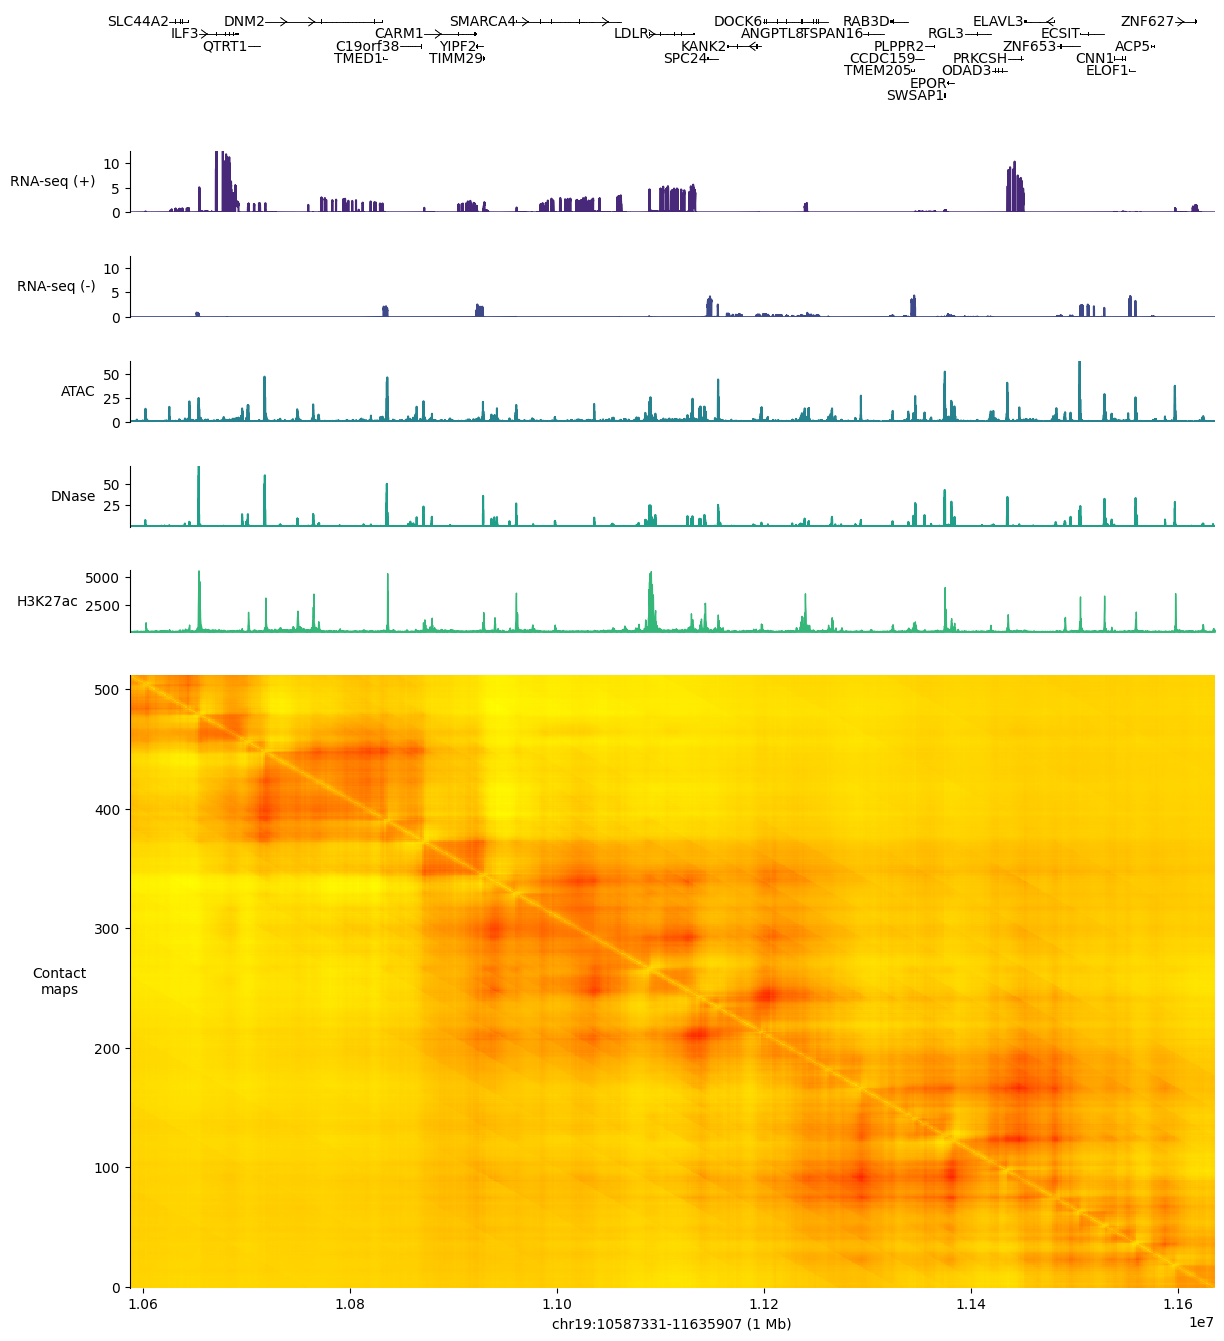

In [6]:
def _get_colors_hex(cmap_name, n):
    cmap = matplotlib.colormaps[cmap_name]
    return [matplotlib.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, n)][1:]

# Clear GPU cache before prediction
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

# 1MB interval (matching reference notebook coordinates)
interval = genome.Interval('chr19', 10_587_331, 11_635_907, strand='+')

with torch.inference_mode(), autocast_ctx:
    predictions = model.predict_interval(
        interval,
        requested_outputs={
            dna_output.OutputType.RNA_SEQ,
            dna_output.OutputType.DNASE,
            dna_output.OutputType.ATAC,
            dna_output.OutputType.CHIP_TF,
            dna_output.OutputType.CHIP_HISTONE,
            dna_output.OutputType.CONTACT_MAPS,
        },
        ontology_terms=['EFO:0001187'],  # HepG2 cell line
    )

print(f"Peak GPU memory: {torch.cuda.max_memory_allocated() / 1e9:.2f} GB")

colors_hex = _get_colors_hex('viridis', 10)

output_rna_seq = predictions.rna_seq.filter_tracks(
    (predictions.rna_seq.metadata['Assay title'] == 'total RNA-seq').values
)

output_chip_histone = predictions.chip_histone.filter_tracks(
    (predictions.chip_histone.metadata['histone_mark'] == 'H3K27ac').values
)

output_chip_tf = predictions.chip_tf.filter_tracks(
    (
        (predictions.chip_tf.metadata['transcription_factor'] == 'CTCF')
        & (predictions.chip_tf.metadata['genetically_modified'].isnull())
    ).values
)

_ = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(
            transcript_extractor.extract(interval)
        ),
        plot_components.Tracks(
            output_rna_seq,
            ylabel_template='RNA-seq ({strand})',
            track_colors=colors_hex[0:2],
            shared_y_scale=True,
        ),
        plot_components.Tracks(
            predictions.atac,
            ylabel_template='ATAC',
            track_colors=colors_hex[3],
            shared_y_scale=True,
        ),
        plot_components.Tracks(
            predictions.dnase,
            ylabel_template='DNase',
            track_colors=colors_hex[4],
            shared_y_scale=True,
        ),
        plot_components.Tracks(
            output_chip_histone,
            ylabel_template='H3K27ac',
            filled=True,
            track_colors=colors_hex[5],
            shared_y_scale=True,
        ),
        plot_components.Tracks(
            output_chip_tf,
            ylabel_template='CTCF',
            filled=True,
            track_colors=colors_hex[6],
            shared_y_scale=True,
        ),
        plot_components.ContactMaps(
            predictions.contact_maps,
            ylabel_template='Contact\nmaps',
        ),
    ],
    interval=interval,
    fig_width=14,
    xlabel='{}:{}-{} (1 Mb)'.format(
        interval.chromosome, interval.start, interval.end
    ),
)

# Clear memory after figure
del predictions, output_rna_seq, output_chip_histone, output_chip_tf
if torch.cuda.is_available():
    torch.cuda.empty_cache()

### Figure 3c

This figure shows an example of a variant causing alternative splice junction
formation in the *COL6A2* gene by creating a new splicing donor and disrupting
the extant one. Predicted tracks are from the Aorta tissue.

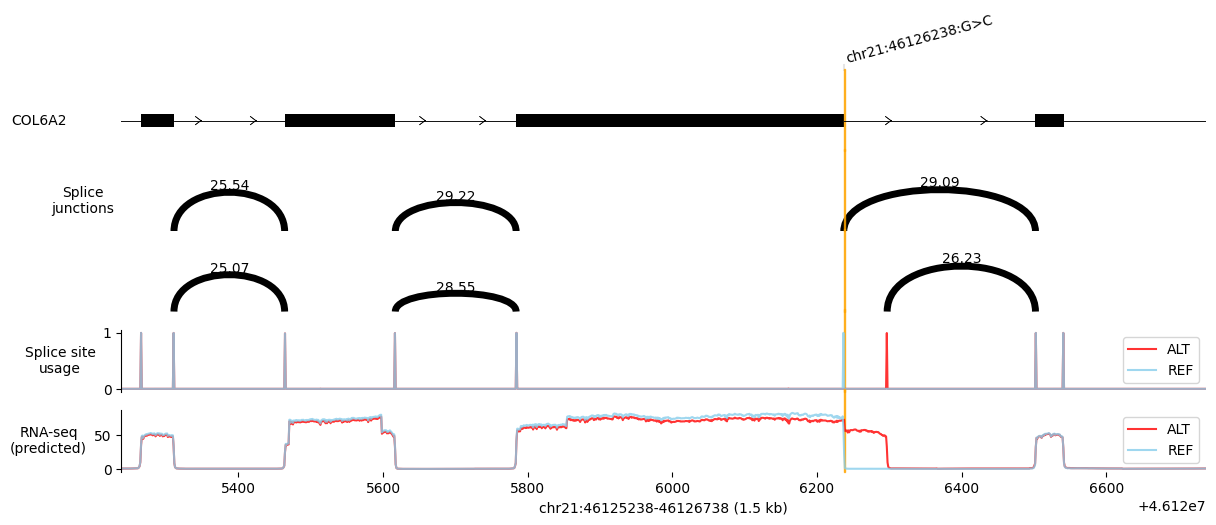

In [7]:
# Clear GPU cache before prediction
if torch.cuda.is_available():
    torch.cuda.empty_cache()

variant = genome.Variant.from_str('chr21:46126238:G>C')
interval = variant.reference_interval.resize(2**20)

with torch.inference_mode(), autocast_ctx:
    predictions = model.predict_variant(
        interval,
        variant,
        requested_outputs=[
            dna_output.OutputType.SPLICE_JUNCTIONS,
            dna_output.OutputType.SPLICE_SITE_USAGE,
            dna_output.OutputType.RNA_SEQ,
        ],
        ontology_terms=['UBERON:0001496'],  # Aorta
    )

ref_alt_colors = {'REF': 'skyblue', 'ALT': 'red'}
plot_interval = genome.Interval.from_str('chr21:46125238-46126738')
rng = np.random.default_rng(seed=42)

ref_splice_sites = predictions.reference.splice_site_usage
ref_splice_sites = ref_splice_sites.filter_tracks(
    (ref_splice_sites.metadata['Assay title'] == 'polyA plus RNA-seq').values
)

alt_splice_sites = predictions.alternate.splice_site_usage
alt_splice_sites = alt_splice_sites.filter_tracks(
    (alt_splice_sites.metadata['Assay title'] == 'polyA plus RNA-seq').values
)

_ = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(
            transcript_extractor.extract(interval)
        ),
        plot_components.Sashimi(
            predictions.reference.splice_junctions.filter_by_tissue(
                'Artery_Aorta'
            ).filter_to_strand(
                '+'
            ),
            ylabel_template='Splice\njunctions',
            normalize_values=False,
            rng=rng,
        ),
        plot_components.Sashimi(
            predictions.alternate.splice_junctions.filter_by_tissue(
                'Artery_Aorta'
            ).filter_to_strand(
                '+'
            ),
            ylabel_template='',
            normalize_values=False,
            rng=rng,
        ),
        plot_components.OverlaidTracks(
            tdata={
                'REF': ref_splice_sites.filter_to_positive_strand(),
                'ALT': alt_splice_sites.filter_to_positive_strand(),
            },
            colors=ref_alt_colors,
            ylabel_template='Splice site\nusage',
        ),
        plot_components.OverlaidTracks(
            tdata={
                'REF': predictions.reference.rna_seq.filter_to_unstranded(),
                'ALT': predictions.alternate.rna_seq.filter_to_unstranded(),
            },
            colors=ref_alt_colors,
            ylabel_template='RNA-seq\n(predicted)',
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=plot_interval,
    fig_width=14,
    xlabel='{}:{}-{} (1.5 kb)'.format(
        plot_interval.chromosome, plot_interval.start, plot_interval.end
    ),
)

# Clear memory after figure
del predictions, ref_splice_sites, alt_splice_sites
if torch.cuda.is_available():
    torch.cuda.empty_cache()

### Figure 4b

Example predictions for a known eQTL (chr22:36201698:A>C) with SuSiE PIP > 0.9 in GTEx Colon (Sigmoid) tissue.

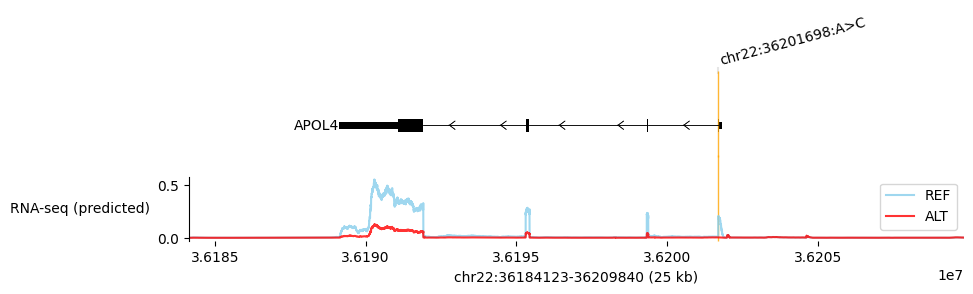

In [8]:
# Clear GPU cache before prediction
if torch.cuda.is_available():
    torch.cuda.empty_cache()

variant = genome.Variant.from_str('chr22:36201698:A>C')
# 1MB interval
interval = variant.reference_interval.resize(2**20)

with torch.inference_mode(), autocast_ctx:
    predictions = model.predict_variant(
        interval,
        variant,
        requested_outputs=[dna_output.OutputType.RNA_SEQ],
        ontology_terms=['UBERON:0001159'],  # Colon Sigmoid
    )

ref_alt_colors = {'REF': 'skyblue', 'ALT': 'red'}
# 25kb view centered on variant (matching reference notebook)
plot_interval = genome.Interval.from_str('chr22:36184123-36209840')

_ = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(
            transcript_extractor.extract(interval)
        ),
        plot_components.OverlaidTracks(
            tdata={
                'REF': predictions.reference.rna_seq.filter_to_unstranded(),
                'ALT': predictions.alternate.rna_seq.filter_to_unstranded(),
            },
            colors=ref_alt_colors,
            ylabel_template='RNA-seq (predicted)',
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=plot_interval,
    fig_width=10,
    xlabel='{}:{}-{} (25 kb)'.format(
        plot_interval.chromosome, plot_interval.start, plot_interval.end
    ),
)

# Clear memory after figure
del predictions
if torch.cuda.is_available():
    torch.cuda.empty_cache()

### Figure 5e

Example AlphaGenome predictions for selected caQTLs. Shown are ALT-REF differences in a predicted DNase track (GM12878).

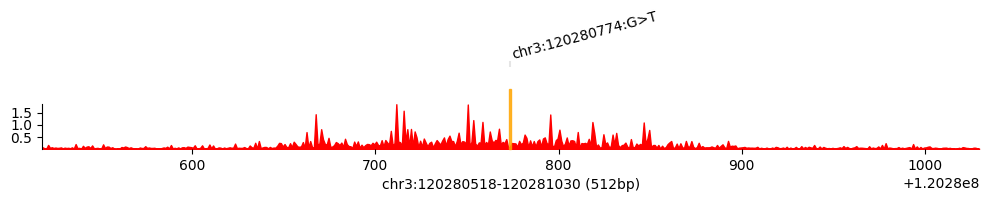

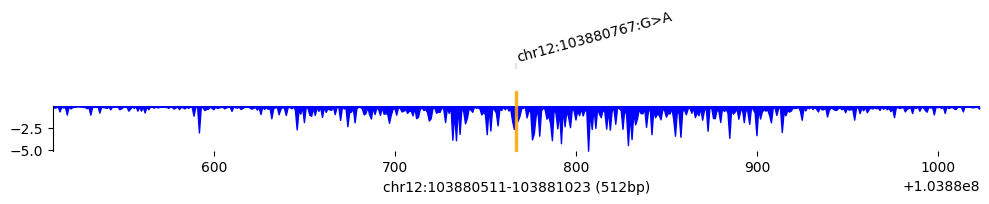

In [9]:
# Clear GPU cache before prediction
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# First variant
variant = genome.Variant.from_str('chr3:120280774:G>T')
interval = variant.reference_interval.resize(2**20)

with torch.inference_mode(), autocast_ctx:
    predictions = model.predict_variant(
        interval,
        variant,
        requested_outputs=[dna_output.OutputType.DNASE],
        ontology_terms=['EFO:0002784'],  # GM12878
    )

# Plot a 512bp region centered on variant (matching reference notebook coordinates)
plot_interval = genome.Interval.from_str('chr3:120280518-120281030')

figure = plot_components.plot(
    [
        plot_components.Tracks(
            predictions.alternate.dnase - predictions.reference.dnase,
            ylabel_template='',
            track_colors='red',
            filled=True,
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=plot_interval,
    fig_width=10,
    xlabel='{}:{}-{} (512bp)'.format(
        plot_interval.chromosome, plot_interval.start, plot_interval.end
    ),
)
figure.tight_layout()

# Clear memory
del predictions
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Second variant
variant = genome.Variant.from_str('chr12:103880767:G>A')
interval = variant.reference_interval.resize(2**20)

with torch.inference_mode(), autocast_ctx:
    predictions = model.predict_variant(
        interval,
        variant,
        requested_outputs=[dna_output.OutputType.DNASE],
        ontology_terms=['EFO:0002784'],  # GM12878
    )

# Plot a 512bp region centered on variant
plot_interval = interval.resize(512)

figure = plot_components.plot(
    [
        plot_components.Tracks(
            predictions.alternate.dnase - predictions.reference.dnase,
            ylabel_template='',
            track_colors='blue',
            filled=True,
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=plot_interval,
    fig_width=10,
    xlabel='{}:{}-{} (512bp)'.format(
        plot_interval.chromosome, plot_interval.start, plot_interval.end
    ),
)
figure.tight_layout()

# Clear memory
del predictions
if torch.cuda.is_available():
    torch.cuda.empty_cache()

### Figure 6b

Detailed ALT-REF predictions for an oncogenic insertion (chr1:47239296:C>ACG) characterized in Mansour *et al.* 2014.

Notebook complete!


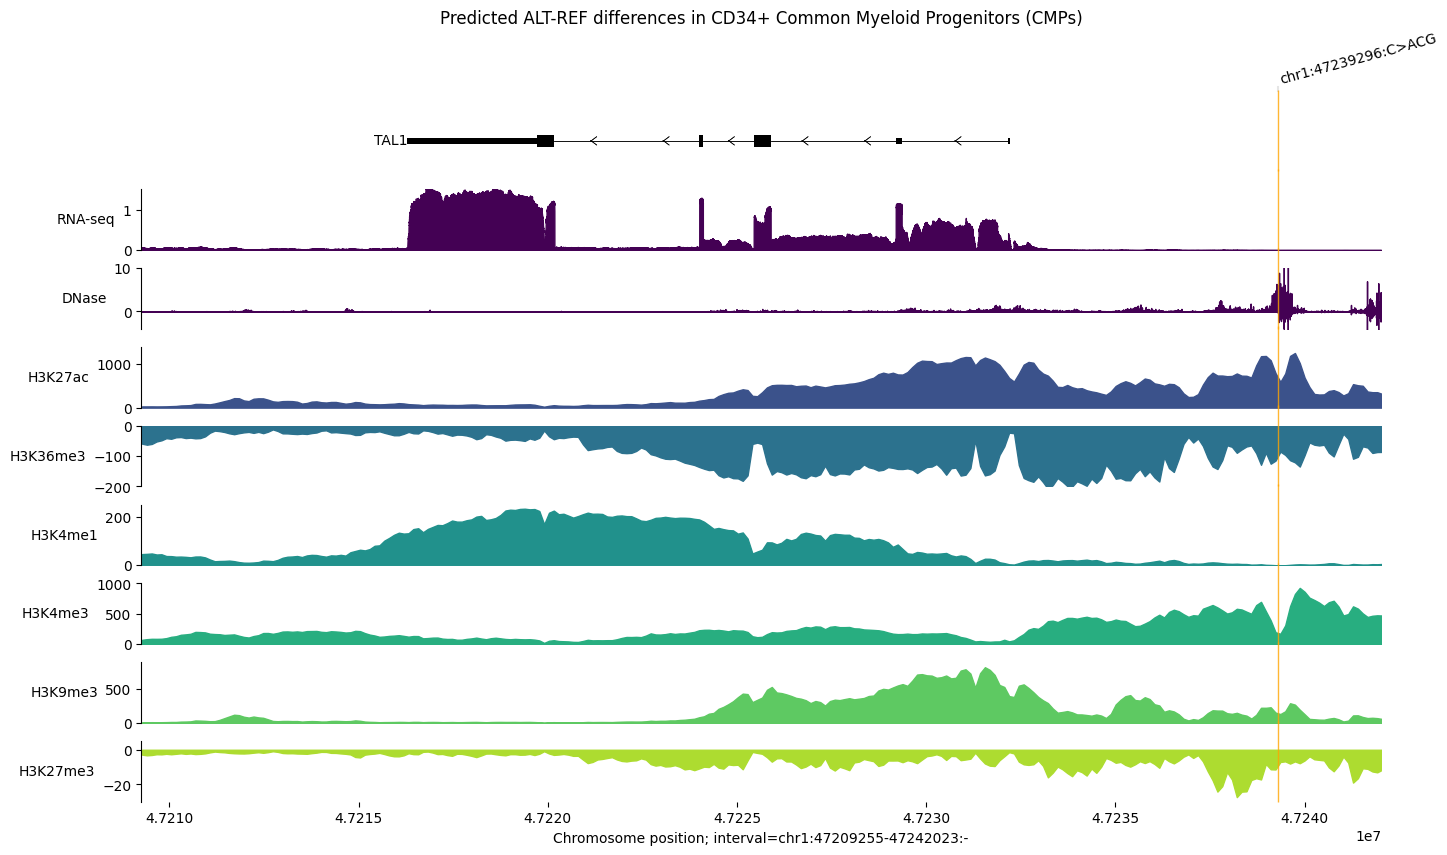

In [10]:
# Clear GPU cache before prediction
if torch.cuda.is_available():
    torch.cuda.empty_cache()

variant = genome.Variant.from_str('chr1:47239296:C>ACG')
# 128kb interval (matching reference notebook)
interval = variant.reference_interval.resize(2**17)

with torch.inference_mode(), autocast_ctx:
    prediction = model.predict_variant(
        interval,
        variant,
        ontology_terms=['CL:0001059'],  # CD34+ Common Myeloid Progenitors
        requested_outputs={
            dna_output.OutputType.RNA_SEQ,
            dna_output.OutputType.CHIP_HISTONE,
            dna_output.OutputType.DNASE,
        },
    )

# TAL1 interval for plotting (matching reference notebook)
tal1_interval = genome.Interval.from_str('chr1:47209255-47242023:-')

# Get chip_histone ALT-REF for negative strand
chip_alt_ref = (
    prediction.alternate.chip_histone.filter_to_nonpositive_strand()
    - prediction.reference.chip_histone.filter_to_nonpositive_strand()
)


def _get_colors_hex(cmap_name, n):
    cmap = matplotlib.colormaps[cmap_name]
    return [matplotlib.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, n)][1:]


colors_hex = _get_colors_hex('viridis', 9)

_ = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(
            transcript_extractor.extract(interval)
        ),
        # RNA-seq tracks.
        plot_components.Tracks(
            tdata=(
                prediction.alternate.rna_seq.filter_to_nonpositive_strand()
                - prediction.reference.rna_seq.filter_to_nonpositive_strand()
            ),
            ylabel_template='RNA-seq',
            shared_y_scale=True,
            filled=True,
            global_ylims=(0, 1.5),
        ),
        # DNase tracks.
        plot_components.Tracks(
            tdata=(
                prediction.alternate.dnase.filter_to_nonpositive_strand()
                - prediction.reference.dnase.filter_to_nonpositive_strand()
            ),
            ylabel_template='DNase',
            shared_y_scale=True,
            filled=True,
            global_ylims=(-4, 10),
        ),
        # ChIP histone (using index-based filtering like reference notebook).
        plot_components.Tracks(
            chip_alt_ref.filter_tracks(np.eye(1, 6, 0, dtype=bool)[0]),
            ylabel_template='H3K27ac',
            shared_y_scale=True,
            global_ylims=(0, 1400),
            filled=True,
            track_colors=colors_hex[1],
        ),
        plot_components.Tracks(
            chip_alt_ref.filter_tracks(np.eye(1, 6, 1, dtype=bool)[0]),
            ylabel_template='H3K36me3',
            shared_y_scale=True,
            filled=True,
            global_ylims=(-200, 0),
            track_colors=colors_hex[2],
        ),
        plot_components.Tracks(
            chip_alt_ref.filter_tracks(np.eye(1, 6, 2, dtype=bool)[0]),
            ylabel_template='H3K4me1',
            shared_y_scale=True,
            filled=True,
            global_ylims=(0, 250),
            track_colors=colors_hex[3],
        ),
        plot_components.Tracks(
            chip_alt_ref.filter_tracks(np.eye(1, 6, 3, dtype=bool)[0]),
            ylabel_template='H3K4me3',
            shared_y_scale=True,
            filled=True,
            global_ylims=(0, 1000),
            track_colors=colors_hex[4],
        ),
        plot_components.Tracks(
            chip_alt_ref.filter_tracks(np.eye(1, 6, 4, dtype=bool)[0]),
            ylabel_template='H3K9me3',
            shared_y_scale=True,
            filled=True,
            global_ylims=(0, 900),
            track_colors=colors_hex[5],
        ),
        plot_components.Tracks(
            chip_alt_ref.filter_tracks(np.eye(1, 6, 5, dtype=bool)[0]),
            ylabel_template='H3K27me3',
            shared_y_scale=True,
            filled=True,
            global_ylims=(-30, 5),
            track_colors=colors_hex[6],
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=tal1_interval,
    fig_width=16,
    title=(
        'Predicted ALT-REF differences in CD34+ Common Myeloid Progenitors'
        ' (CMPs)'
    ),
)

# Final memory cleanup
del prediction
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Notebook complete!")